## <span color = 'red'> Peaks and Holes Forming Analysis 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.stats import linregress
import cv2
from preprocessing import preprocessing_v2 as pp
from pathlib import Path
from utils.file_util_exec import path_to_str
from utils import analysis_utils as au

In [2]:
DATA_PATH = Path(r'D:\amityu\backoffice_data\\')
movie =Path('130721_CCA60')
MOVIE_PATH = DATA_PATH /  movie 
GRAPH_PATH = Path('C:/Users/amityu/Gel_Sheet_Graph/')
ex_data = pp.get_ex_data(path_to_str(MOVIE_PATH) )


In [3]:
# Load the blob dataframe

if_surface = False
if_membrane= ~if_surface
if if_surface:
    df = pd.read_csv(MOVIE_PATH / Path('np/blobs.csv'))
    image_sequence = pp.get_merged_spike(path_to_str(MOVIE_PATH),ex_data)
if if_membrane:
    gel = np.load(MOVIE_PATH/ Path('np/gel_norm.npy'))
    df = pd.read_csv(MOVIE_PATH / Path('np/membrane_blobs.csv'))
    membrane = np.load(MOVIE_PATH/ Path('np/membrane.npy'))
    image_sequence = au.get_surface_intensity(gel, membrane)
# Display the first few rows
print(df.head())

# Example of the dataframe structure:
#    frame     y      x   sigma radius height intensity
# 0      1  100.5  150.3   5.2
# 1      1  200.7  250.8   4.8
# 2      2  105.2  155.1   5.5
# ...


   Unnamed: 0      y      x  sigma    radius    height  intensity  frame
0           0  413.0  474.0    1.0  1.414214  0.532388   0.532388      0
1           1   31.0  347.0    1.0  1.414214  0.553792   0.553792      0
2           2  422.0    0.0    1.0  1.414214  0.638768   0.638768      0
3           3   52.0  382.0    1.0  1.414214  0.544542   0.544542      0
4           4  297.0  285.0    1.0  1.414214  0.572720   0.572720      0


Total number of frames: 62
Total number of blobs detected: 385327


C:\Users\amityu\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\amityu\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\amityu\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

C:\Users\amityu\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



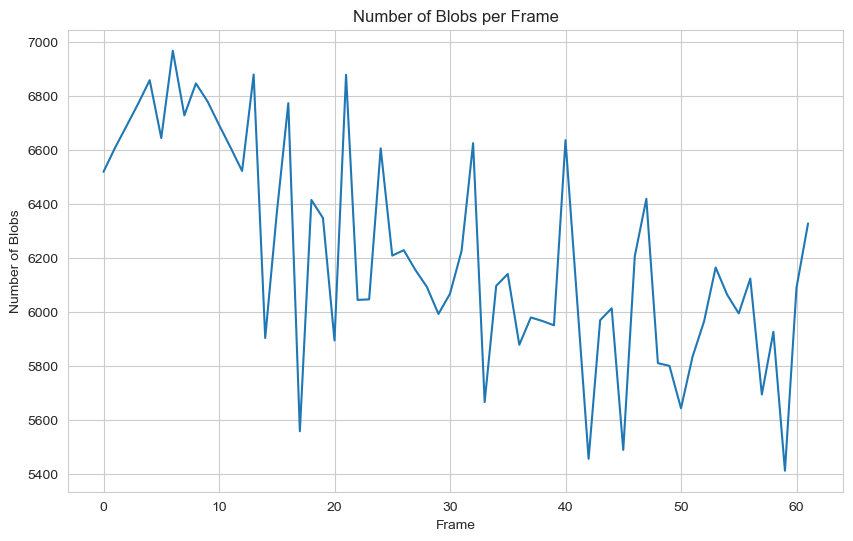

C:\Users\amityu\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\amityu\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



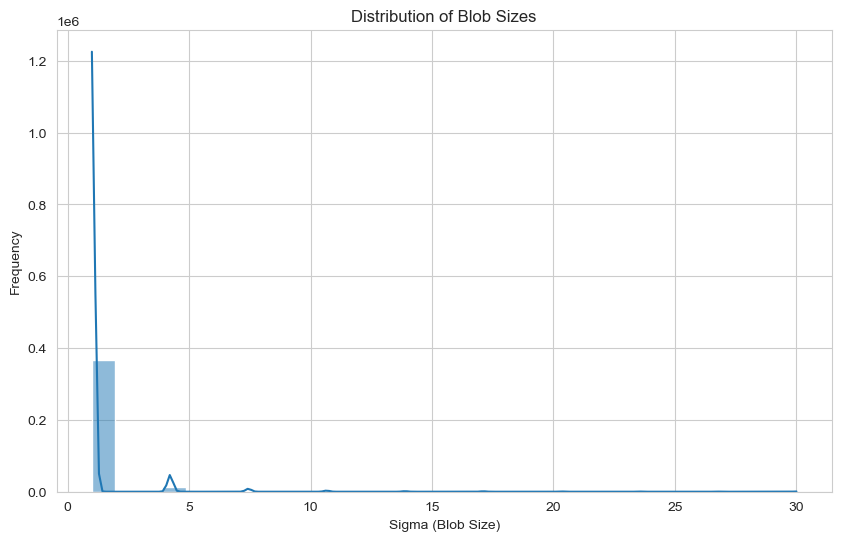

In [4]:
# Total number of frames
num_frames = df['frame'].nunique()
print(f"Total number of frames: {num_frames}")

# Total number of blobs
total_blobs = len(df)
print(f"Total number of blobs detected: {total_blobs}")

# Blobs per frame
blobs_per_frame = df['frame'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
sns.lineplot(x=blobs_per_frame.index, y=blobs_per_frame.values)
plt.xlabel('Frame')
plt.ylabel('Number of Blobs')
plt.title('Number of Blobs per Frame')
plt.show()

# Distribution of blob sizes (sigma)
plt.figure(figsize=(10, 6))
sns.histplot(df['sigma'], bins=30, kde=True)
plt.xlabel('Sigma (Blob Size)')
plt.ylabel('Frequency')
plt.title('Distribution of Blob Sizes')
plt.show()


C:\Users\amityu\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\amityu\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\amityu\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

C:\Users\amityu\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



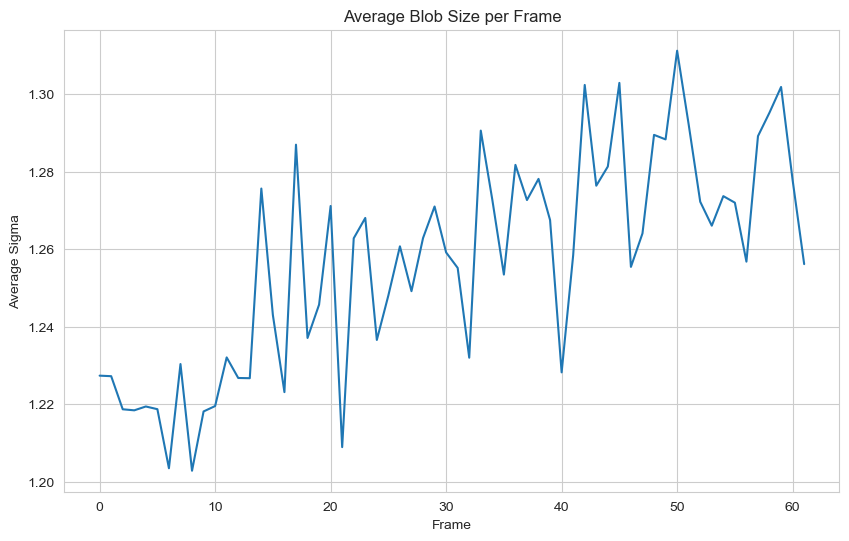

C:\Users\amityu\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\amityu\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



Coarsening exponent (slope): 0.019


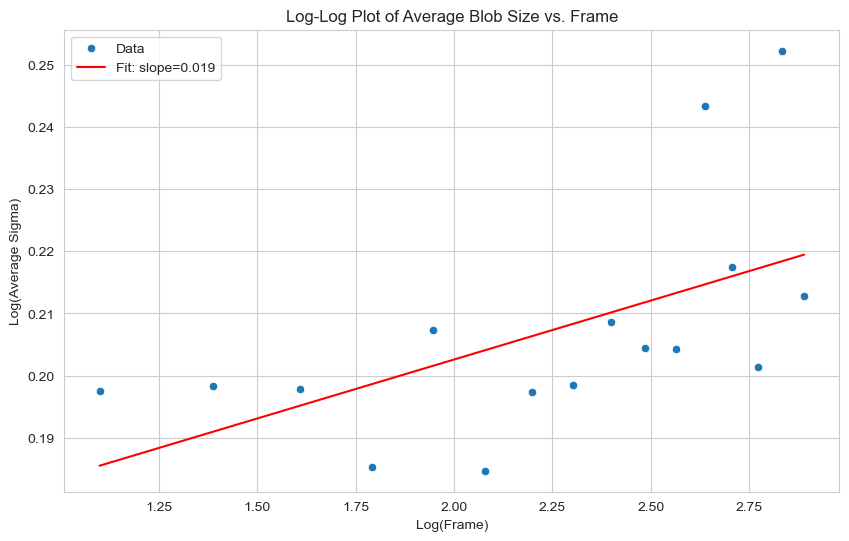

In [5]:
# Average blob size per frame
avg_sigma_per_frame = df.groupby('frame')['sigma'].mean()

plt.figure(figsize=(10, 6))
sns.lineplot(x=avg_sigma_per_frame.index, y=avg_sigma_per_frame.values)
plt.xlabel('Frame')
plt.ylabel('Average Sigma')
plt.title('Average Blob Size per Frame')
plt.show()

# Fit a linear model to log-average sigma vs log-time to determine coarsening exponent
# Assuming frame number is proportional to time

log_time = np.log(avg_sigma_per_frame.index.values[3:19])
log_sigma = np.log(avg_sigma_per_frame.values[3:19])

slope, intercept, r_value, p_value, std_err = linregress(log_time, log_sigma)
print(f"Coarsening exponent (slope): {slope:.3f}")

# Plot with fitted line
plt.figure(figsize=(10, 6))
sns.scatterplot(x=log_time, y=log_sigma, label='Data')
plt.plot(log_time, intercept + slope * log_time, 'r', label=f'Fit: slope={slope:.3f}')
plt.xlabel('Log(Frame)')
plt.ylabel('Log(Average Sigma)')
plt.title('Log-Log Plot of Average Blob Size vs. Frame')
plt.legend()
plt.show()


C:\Users\amityu\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\amityu\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

C:\Users\amityu\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\amityu\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

C:\Users\amityu\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWa

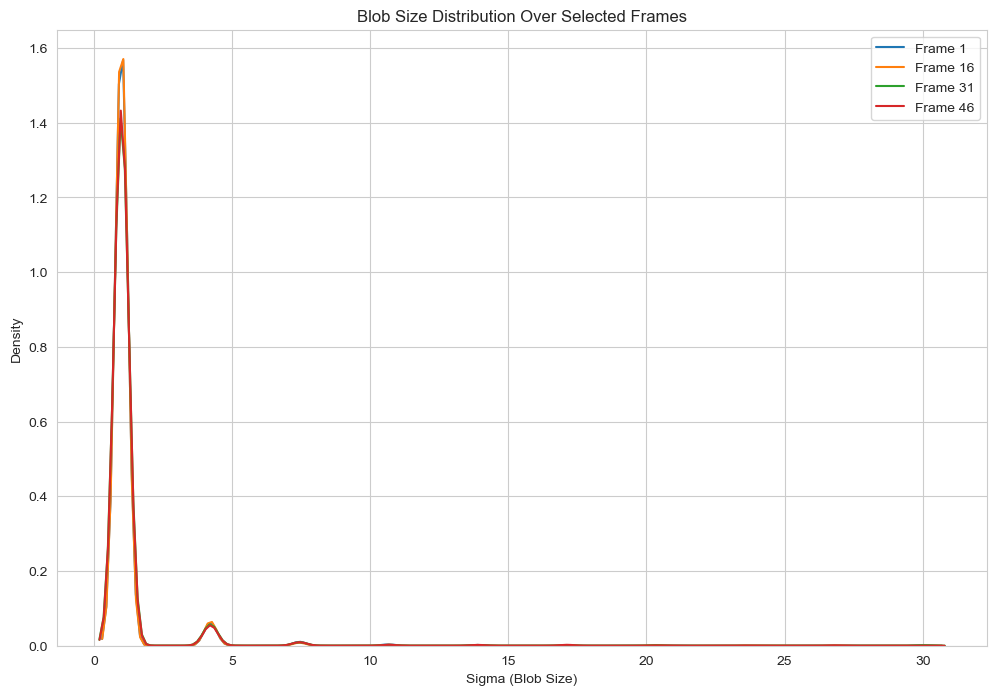

In [6]:
# Select frames to visualize distributions
selected_frames = np.linspace(1, num_frames, num=5, dtype=int)

plt.figure(figsize=(12, 8))
for frame in selected_frames:
    subset = df[df['frame'] == frame]
    sns.kdeplot(subset['sigma'], label=f'Frame {frame}')
plt.xlabel('Sigma (Blob Size)')
plt.ylabel('Density')
plt.title('Blob Size Distribution Over Selected Frames')
plt.legend()
plt.show()


In [7]:
np.log(19)
np.exp(1.1)

3.0041660239464334

C:\Users\amityu\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\amityu\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\amityu\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

C:\Users\amityu\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



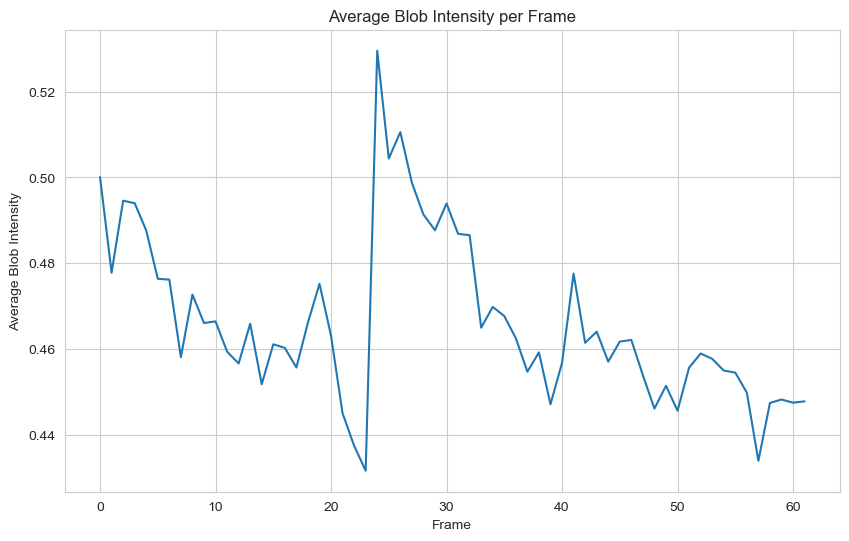

C:\Users\amityu\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\amityu\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



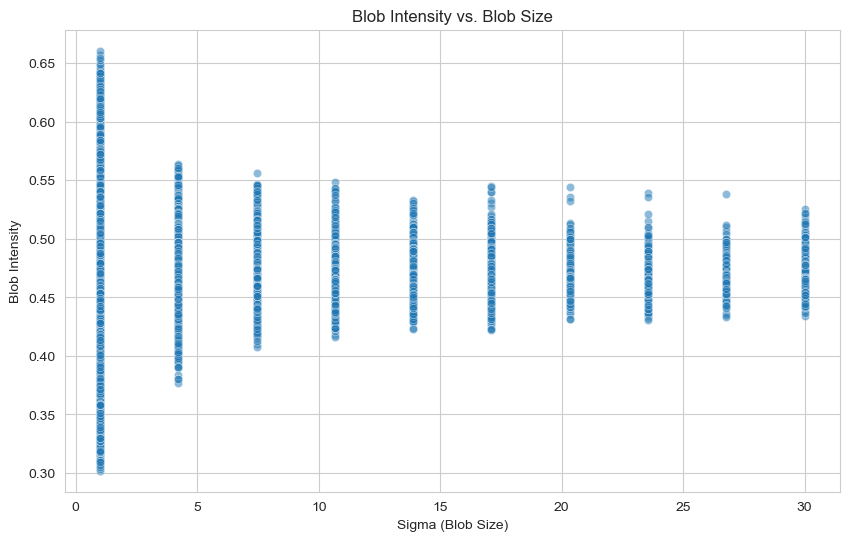

Correlation between blob size and intensity: 0.012


In [8]:
# Average intensity per frame
avg_intensity_per_frame = df.groupby('frame')['intensity'].mean()

plt.figure(figsize=(10, 6))
sns.lineplot(x=avg_intensity_per_frame.index, y=avg_intensity_per_frame.values)
plt.xlabel('Frame')
plt.ylabel('Average Blob Intensity')
plt.title('Average Blob Intensity per Frame')
plt.show()

# Correlation between blob size and intensity
plt.figure(figsize=(10, 6))
sns.scatterplot(x='sigma', y='intensity', data=df, alpha=0.5)
plt.xlabel('Sigma (Blob Size)')
plt.ylabel('Blob Intensity')
plt.title('Blob Intensity vs. Blob Size')
plt.show()

# Compute correlation coefficient
correlation = df['sigma'].corr(df['intensity'])
print(f"Correlation between blob size and intensity: {correlation:.3f}")


In [9]:
from scipy.spatial import cKDTree

# Initialize a dictionary to hold tracks
tracks = {}
current_track_id = 0

# Sort dataframe by frame
df_sorted = df.sort_values('frame')

# Parameters
max_distance = 20  # Maximum distance to consider the same blob across frames

# Iterate through frames
for frame in range(1, num_frames + 1):
    frame_blobs = df_sorted[df_sorted['frame'] == frame]
    if frame == 1:
        # Initialize tracks with first frame
        for idx, blob in frame_blobs.iterrows():
            tracks[current_track_id] = {'frames': [frame], 'y': [blob['y']], 'x': [blob['x']], 'sigma': [blob['sigma']]}
            df_sorted.at[idx, 'track_id'] = current_track_id
            current_track_id += 1
    else:
        # Get previous frame blobs with track IDs
        prev_frame = frame - 1
        prev_blobs = df_sorted[df_sorted['frame'] == prev_frame]
        prev_coords = prev_blobs[['y', 'x']].values
        prev_ids = prev_blobs['track_id'].values
        if len(prev_coords) == 0:
            # No previous blobs to track
            for idx, blob in frame_blobs.iterrows():
                tracks[current_track_id] = {'frames': [frame], 'y': [blob['y']], 'x': [blob['x']], 'sigma': [blob['sigma']]}
                df_sorted.at[idx, 'track_id'] = current_track_id
                current_track_id += 1
            continue
        # Build KD-tree for previous blobs
        tree = cKDTree(prev_coords)
        # Current frame blob coordinates
        current_coords = frame_blobs[['y', 'x']].values
        # Query nearest neighbors
        distances, indices = tree.query(current_coords, distance_upper_bound=max_distance)
        for i, (distance, index) in enumerate(zip(distances, indices)):
            if distance != np.inf:
                # Assign the track ID of the nearest previous blob
                track_id = prev_ids[index]
                tracks[track_id]['frames'].append(frame)
                tracks[track_id]['y'].append(current_coords[i][0])
                tracks[track_id]['x'].append(current_coords[i][1])
                tracks[track_id]['sigma'].append(frame_blobs.iloc[i]['sigma'])
                df_sorted.iloc[frame_blobs.index[i], df_sorted.columns.get_loc('track_id')] = track_id
            else:
                # Assign a new track ID
                tracks[current_track_id] = {'frames': [frame], 'y': [current_coords[i][0]], 'x': [current_coords[i][1]], 'sigma': [frame_blobs.iloc[i]['sigma']]}
                df_sorted.iloc[frame_blobs.index[i], df_sorted.columns.get_loc('track_id')] = current_track_id
                current_track_id += 1

# Display some tracks
for track_id, track in list(tracks.items())[:5]:
    print(f"Track {track_id}: Frames {track['frames']}, Positions {list(zip(track['y'], track['x']))}, Sigma {track['sigma']}")


Track 0: Frames [1, 2, 2, 3, 4, 5, 6, 7, 7, 8, 8, 8, 8, 8, 9, 9, 9, 9, 10, 10, 10, 11, 11, 12, 13, 13], Positions [(350.0, 141.0), (350.0, 138.0), (349.0, 143.0), (266.0, 307.0), (194.0, 164.0), (445.0, 183.0), (173.0, 401.0), (212.0, 7.0), (215.0, 5.0), (234.0, 18.0), (378.0, 368.0), (228.0, 19.0), (233.0, 20.0), (377.0, 365.0), (29.0, 294.0), (12.0, 48.0), (14.0, 44.0), (53.0, 89.0), (354.0, 446.0), (457.0, 74.0), (405.0, 210.0), (88.0, 115.0), (192.0, 141.0), (96.0, 274.0), (85.0, 467.0), (82.0, 468.0)], Sigma [1.0, 1.0, 1.0, 1.0, 1.0, 4.222222222222222, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Track 1: Frames [1, 2], Positions [(405.0, 191.0), (404.0, 190.0)], Sigma [1.0, 1.0]
Track 2: Frames [1, 2], Positions [(309.0, 112.0), (311.0, 113.0)], Sigma [1.0, 4.222222222222222]
Track 3: Frames [1], Positions [(87.0, 13.0)], Sigma [1.0]
Track 4: Frames [1], Positions [(113.0, 483.0)], Sigma [1.0]


MovieWriter imagemagick unavailable; using Pillow instead.


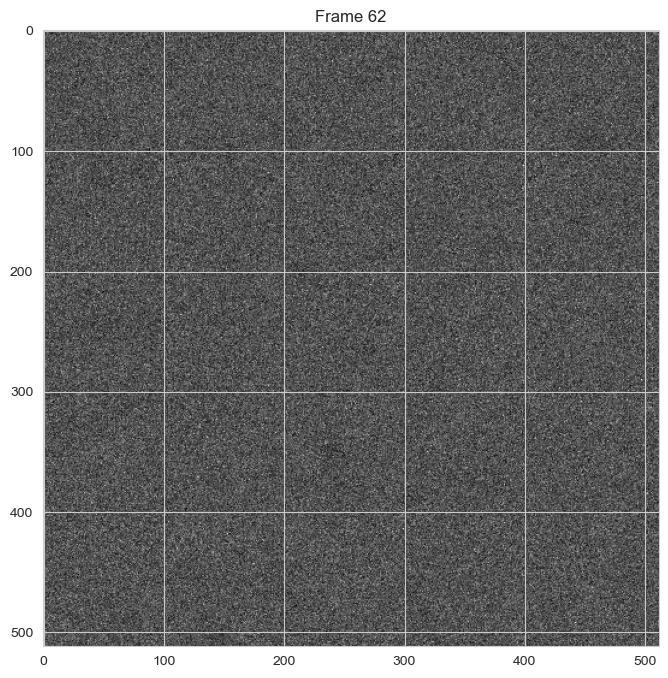

In [10]:
import matplotlib.patches as patches
from matplotlib import animation

# Load all images
images = image_sequence

# Normalize images
images = [img / img.max() for img in images]

# Create a figure
fig, ax = plt.subplots(figsize=(8, 8))

def init():
    ax.imshow(images[0], cmap='gray')
    return []

def animate(frame_num):
    ax.clear()
    ax.imshow(images[frame_num], cmap='gray')
    # Plot blobs
    frame = frame_num + 1  # Assuming frame numbering starts at 1
    blobs = df[df['frame'] == frame]
    for _, blob in blobs.iterrows():
        circ = patches.Circle((blob['x'], blob['y']), radius=blob['sigma']*3, edgecolor='red', facecolor='none', linewidth=1)
        ax.add_patch(circ)
    ax.set_title(f'Frame {frame}')
    return []

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=num_frames, interval=200, blit=False)

# To display the animation in a Jupyter notebook
# from IPython.display import HTML
# HTML(anim.to_jshtml())

# To save the animation as a GIF
anim.save('coarsening_animation.gif', writer='imagemagick')


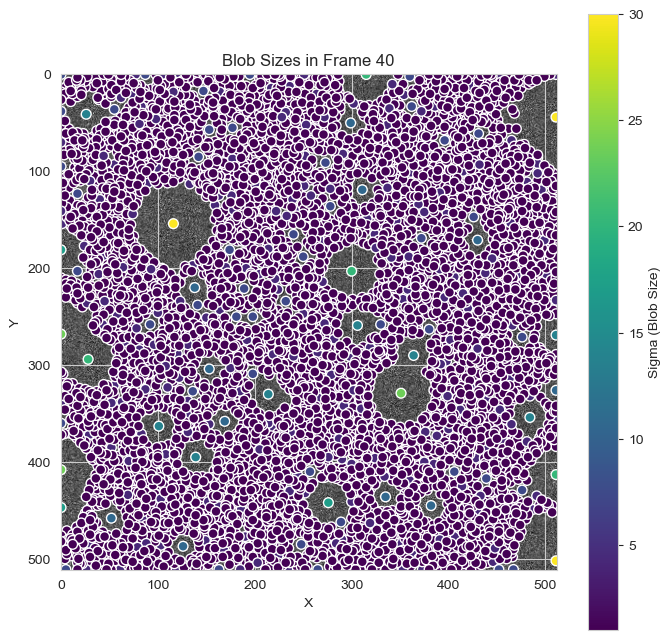

In [11]:
import matplotlib.colors as colors

# Select a frame to visualize
selected_frame = 40  # For example, the last frame

# Load the selected image
image = image_sequence[selected_frame]
if image.ndim == 3:
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image = image / image.max()

# Get blobs for the selected frame
blobs = df[df['frame'] == selected_frame]

plt.figure(figsize=(8, 8))
plt.imshow(image, cmap='gray')
scatter = plt.scatter(blobs['x'], blobs['y'], c=blobs['sigma'], cmap='viridis', s=50, edgecolor='white')
plt.colorbar(scatter, label='Sigma (Blob Size)')
plt.title(f'Blob Sizes in Frame {selected_frame}')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()


Total number of frames loaded: 62


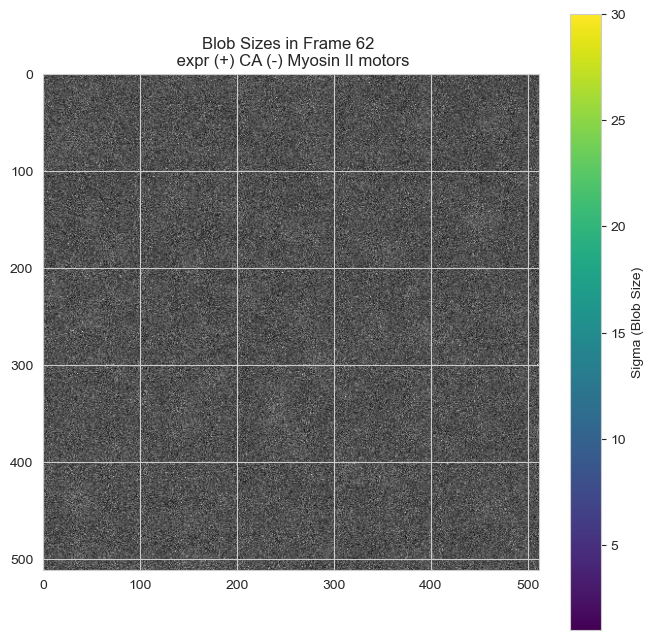

In [12]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.patches as patches
from matplotlib import animation
import pandas as pd
import numpy as np
import cv2
import os

# Total number of frames
num_frames = len(image_sequence)
print(f"Total number of frames loaded: {num_frames}")

# ----------------------------
# Step 2: Prepare the Plot
# ----------------------------

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 8))

# Initialize the plot elements we want to animate
# Display the first image
initial_image = image_sequence[0]
img_display = ax.imshow(initial_image, cmap='gray', animated=True)

# Extract blobs for the first frame
selected_frame = 1  # Assuming frame indexing starts at 1
blobs = df[df['frame'] == selected_frame]

# Create the scatter plot for blobs
scatter = ax.scatter(blobs['x'], blobs['y'], c=blobs['sigma'], cmap='viridis', s=50, edgecolor='white', animated=True)

# Add a colorbar for sigma
cbar = plt.colorbar(scatter, ax=ax, label='Sigma (Blob Size)')

# Set plot titles and labels
title = ax.set_title(f'exp {ex_data["name"]} \n Blob Sizes in Frame {selected_frame}')
ax.set_xlabel('X')
ax.set_ylabel('Y')

# ----------------------------
# Step 3: Define the Animation Function
# ----------------------------

def animate(frame_num):
    """
    Update the image and scatter plot for the given frame number.
    """
    # Update the image
    ax.clear()

    img = image_sequence[frame_num]
    ax.imshow(img, cmap='gray')
    # Clear previous scatter

    # Get blobs for the current frame (assuming frame indexing starts at 1)
    current_frame = frame_num + 1
    blobs = df[df['frame'] == current_frame]

    # Update scatter plot with new blobs
    scatter = ax.scatter(blobs['x'], blobs['y'], c=blobs['sigma'], cmap='viridis', s=50, edgecolor='white')

    # Update title
    ax.set_title(f'Blob Sizes in Frame {current_frame} \n expr {ex_data["name"]}')

    return img_display, scatter, title

# ----------------------------
# Step 4: Create the Animation
# ----------------------------

# Define the number of frames and interval
anim = animation.FuncAnimation(fig, animate, frames=num_frames, interval=200, blit=False)

# ----------------------------
# Step 5: Display or Save the Animation
# ----------------------------

# Option 1: Display the animation inline (useful for Jupyter Notebooks)
# Uncomment the following lines if you're using a Jupyter Notebook

# from IPython.display import HTML
# HTML(anim.to_jshtml())

# Option 2: Save the animation as a GIF
# Ensure you have ImageMagick installed: https://imagemagick.org/script/download.php

# Replace 'coarsening_animation.gif' with your desired output path
anim.save('coarsening_animation.mp4',  fps=5)

# Option 3: Save the animation as an MP4 video
# Ensure you have ffmpeg installed: https://ffmpeg.org/download.html

# anim.save('coarsening_animation.mp4', writer='ffmpeg', fps=5)

# ----------------------------
# Step 6: Show the Plot (Optional)
# ----------------------------

plt.show()


In [13]:
# Using the previously computed log-log slope
print(f"Coarsening exponent: {slope:.3f}")

# The coarsening rate can be inferred from the slope
# For example, if sigma ~ t^n, then slope ≈ n


Coarsening exponent: 0.019


C:\Users\amityu\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\amityu\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

C:\Users\amityu\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\amityu\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

C:\Users\amityu\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWa

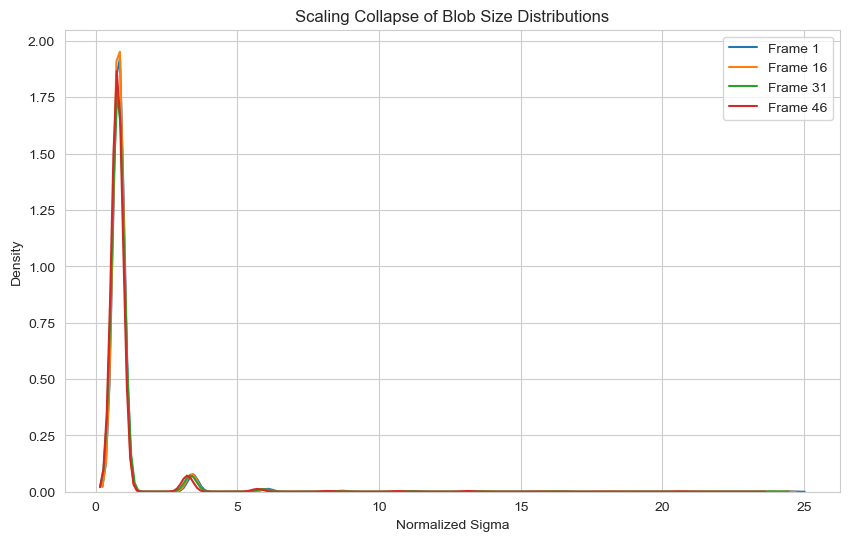

In [14]:
# Compute the characteristic size (e.g., average sigma)
char_size = avg_sigma_per_frame.values

# Normalize blob sizes
df['sigma_normalized'] = df.apply(lambda row: row['sigma'] / char_size[int(row['frame']) - 1], axis=1)

# Plot normalized size distributions
plt.figure(figsize=(10, 6))      
for frame in selected_frames:
    subset = df[df['frame'] == frame]
    sns.kdeplot(subset['sigma_normalized'], label=f'Frame {frame}')
plt.xlabel('Normalized Sigma')
plt.ylabel('Density')
plt.title('Scaling Collapse of Blob Size Distributions')
plt.legend()
plt.show()
